Download colab_utils and import



<a href="https://colab.research.google.com/github/beangoben/intro_dl/blob/master/MNIST_LR_MLP_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [2]:
!wget https://raw.githubusercontent.com/beangoben/workshop_template/master/colab_utils.py -O colab_utils.py
!rm -rf sample_data
import colab_utils
!pip install git+https://github.com/google/flax.git
!pip install umap-learn

--2020-08-25 20:22:12--  https://raw.githubusercontent.com/beangoben/workshop_template/master/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7173 (7.0K) [text/plain]
Saving to: ‘colab_utils.py’

colab_utils.py      100%[===================>]   7.00K  --.-KB/s    in 0.004s  

2020-08-25 20:22:12 (1.64 MB/s) - ‘colab_utils.py’ saved [7173/7173]

  Cloning https://github.com/google/flax.git to /tmp/pip-req-build-e20z2cjd
  Running command git clone -q https://github.com/google/flax.git /tmp/pip-req-build-e20z2cjd
  Created wheel for flax: filename=flax-0.2.0-cp36-none-any.whl size=140760 sha256=0a8cadbba3ce0c8a4deae8cc1f554ced3317f26347125aefbb1bb92417c150ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-6mes6vj1/wheels/df/ef/29/71c694e30a038ecde1

# MUY IMPORTANTE: USA UN GPU O TPU (choose runtime)

# Importa modulos


In [3]:
from collections import OrderedDict
import tqdm.auto as tqdm
from more_itertools import chunked
import colab_utils

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

import umap
import sklearn
# Jax
import jax
from jax import numpy as jnp, random, jit, lax
# Flax
import flax
from flax import nn, optim
# Tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds

_ = jnp.square(2.)

colab_utils.print_module_versions([tf, tfds, jax])
colab_utils.matplotlib_settings()

tensorflow: 2.3.0
tensorflow_datasets: 2.1.0
jax       : 0.1.75


Primero lodearemos algunos datos

In [101]:
dataset = 'fashion_mnist'
#dataset_name = 'mnist'

train_ds = tfds.as_numpy(tfds.load(dataset_name, split=tfds.Split.TRAIN, batch_size=-1))
x_train, y_train = train_ds['image'], train_ds['label']

test_ds = tfds.as_numpy(tfds.load(dataset_name, split=tfds.Split.TEST, batch_size=-1))
x_test, y_test = test_ds['image'], test_ds['label']

# Necesitamos DL? Primero EDA!

In [104]:
def flatten_image(x):
    return np.reshape(x, (x.shape[0],x.shape[1]*x.shape[2]))

flat_x_train = flatten_image(x_train)
flat_y_train = y_train.ravel()

flat_x_test = flatten_image(x_test)
flat_y_test = y_test.ravel()
print(flat_x_train.shape, y_train.shape)
print(flat_x_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


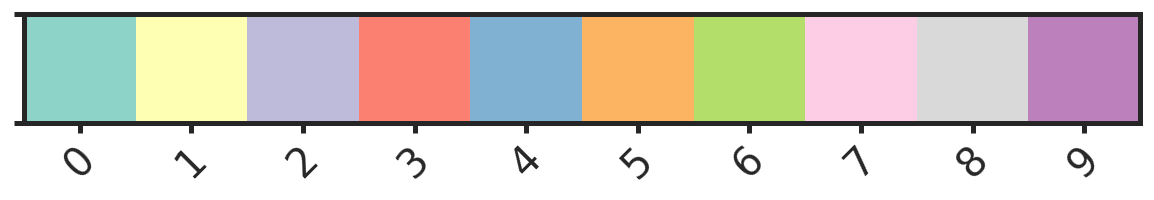

In [105]:
def labels_to_nodecolors(labels):
    """Convierte etqiuetas a colores."""
    cols = sns.color_palette("Set3", 10)
    return [cols[int(l)] for l in labels.ravel()]

def plot_color_legend(dataset_name):
    cols = sns.color_palette("Set3", 10)
    categories = {'fashion_mnist':['T-shirt/top','Trouser',
                                   'Pullover','Dress', 'Coat','Sandal',
               'Shirt','Sneaker','Bag','Ankle boot'],
               'mnist': list(range(10))}[dataset_name]
    sns.palplot(cols)
    plt.xticks(np.arange(10), categories, rotation=45)
    plt.show()
    
plot_color_legend(dataset_name)

In [106]:
import sklearn.pipeline
import sklearn.decomposition
import sklearn.preprocessing

pca_pipe = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()),
                                  ('dim_reduce', sklearn.decomposition.PCA(2))])

umap_pipe = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()),
                                  ('dim_reduce', umap.UMAP())])

umap_pipe.fit(flat_x_train)
x_umap = umap_pipe.transform(flat_x_test)

pca_pipe.fit(flat_x_train)
x_pca = pca_pipe.transform(flat_x_test)

print(x_umap.shape, x_pca.shape)

(10000, 2) (10000, 2)


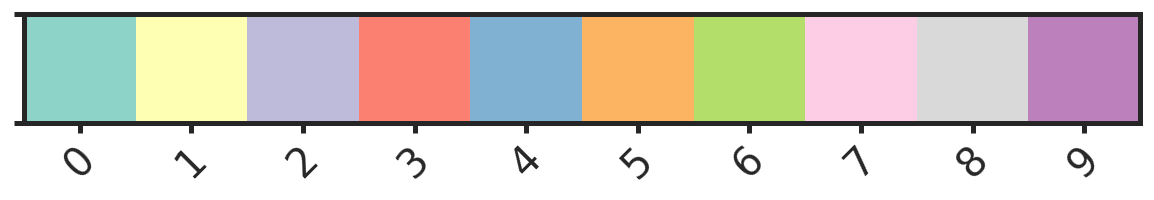

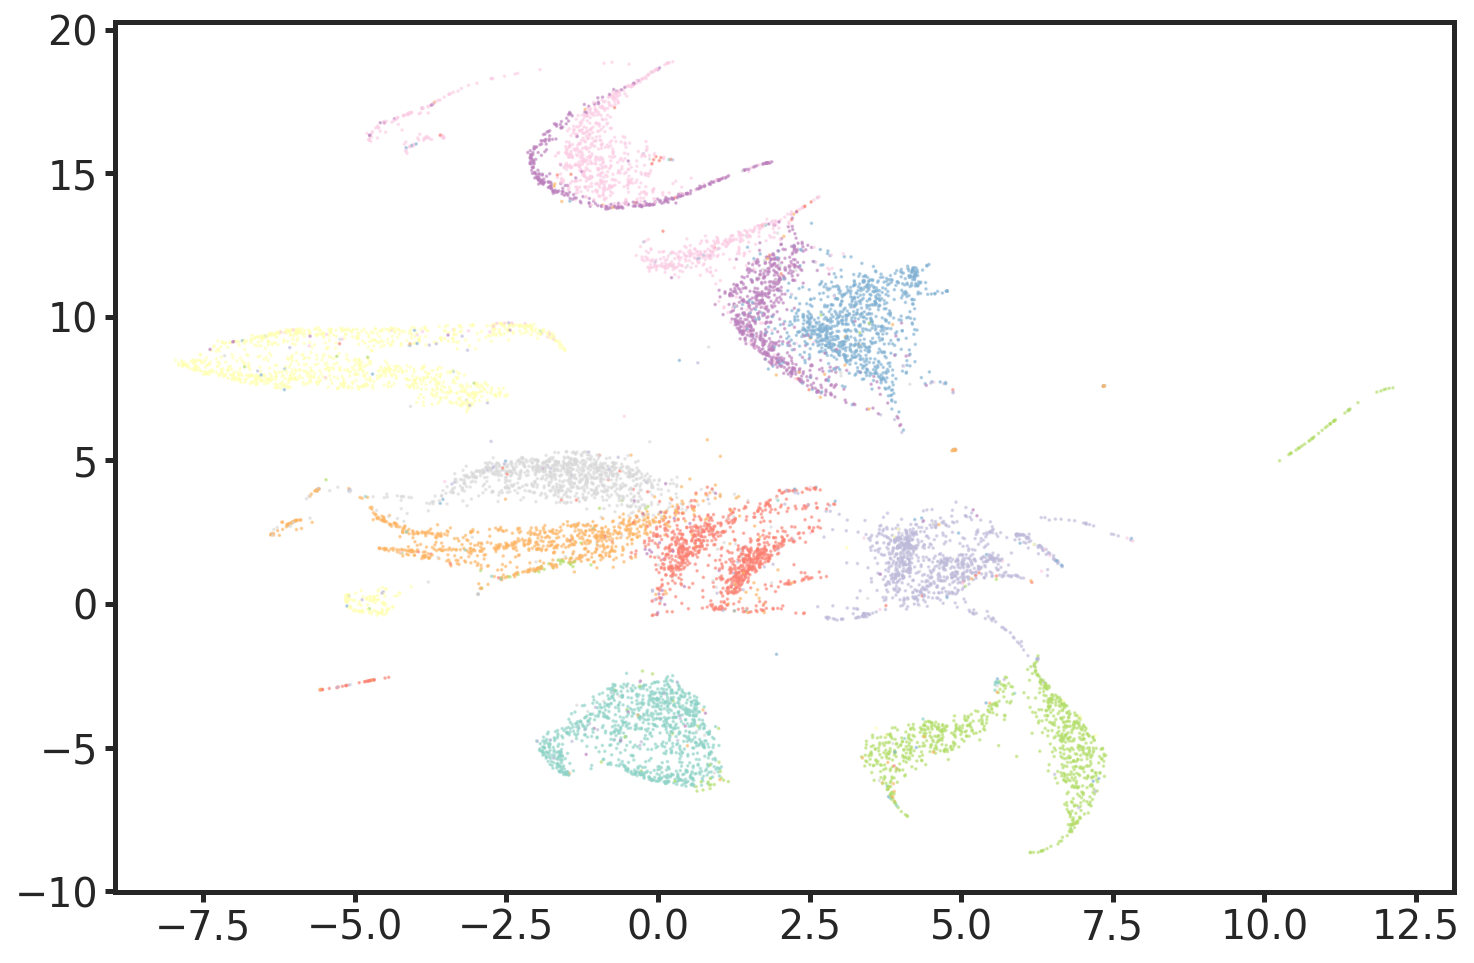

In [107]:
plot_color_legend(dataset_name)
plt.scatter(x_umap[:,0], x_umap[:, 1],
            c=labels_to_nodecolors(flat_y_test),
            s=1, alpha=0.5)
plt.show()

In [109]:
indices = np.random.permutation(len(x_umap))[:5000]

vis_df = pd.DataFrame()
vis_df['UMAP1'] = x_umap[indices, 0]
vis_df['UMAP2'] = x_umap[indices, 1]
vis_df['PC1'] = x_pca[indices, 0]
vis_df['PC2'] = x_pca[indices, 1]
vis_df['label'] = flat_y_test[indices]
vis_df

,UMAP1,UMAP2,PC1,PC2,label
0,-1.301734,4.583663,-5.957450,-0.479001,8
1,-4.568994,8.245726,-7.858150,-1.972410,1
2,7.019829,-5.204327,-1.426350,-0.882822,6
3,0.348856,-6.131595,21.838807,-1.889770,0
4,0.061468,2.245198,-6.588652,0.841986,3
...,...,...,...,...,...
4995,4.652706,1.438549,6.899192,-6.743974,2
4996,-0.000552,18.606033,2.059583,-4.214291,9
4997,-2.438525,4.287101,-4.123477,-5.239532,8
4998,6.584110,-4.490979,9.395984,1.649345,6


In [110]:
alt.Chart(vis_df).mark_circle(size=10).encode(
    x='UMAP1:Q',
    y='UMAP2:Q',
    color='label:N',
    tooltip=['label']
).interactive()

alt.Chart(...)

## Comparativa de PCA/UMAP

In [111]:
brush = alt.selection(type='interval', resolve='global')

scatter1 = alt.Chart(vis_df).mark_circle(size=4).encode(
    x='PC1:Q',
    y='PC2:Q',
    color = alt.condition(brush, alt.Color('label:N'), alt.value('lightgray')),
    tooltip=['label']
).add_selection(brush)

scatter2 = alt.Chart(vis_df).mark_circle(size=4).encode(
    x='UMAP1:Q',
    y='UMAP2:Q',
    color = alt.condition(brush, alt.Color('label:N'), alt.value('lightgray')),
    tooltip=['label']
).add_selection(brush)

scatter1 | scatter2

alt.HConcatChart(...)

# Necesitamos DL? Un modelo lineal

Reloadear datos, ahora con splits

In [65]:
train_ds = tfds.as_numpy(tfds.load(dataset_name, split=tfds.Split.TRAIN, batch_size=-1))
x_train, y_train = train_ds['image'], train_ds['label']

test_ds = tfds.as_numpy(tfds.load(dataset_name, split=tfds.Split.TEST, batch_size=-1))
x_test, y_test = test_ds['image'], test_ds['label']

Queremos :
$$ \hat{y} = W \cdot x + b $$

Talque la diferencia $|y-\hat{y}|$ sea minima (error).

* Cuales son las dimensiones de W y b?
* Cuantos parametros necesitamos "aprender"?
* Que significa aprender?
* Como optimizamos W + b? 


In [66]:
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

N_PIXELS = x_train.shape[1]*x_train.shape[2]
N_LABELS = 10

rng_key = random.PRNGKey(0)
params = [random_layer_params(N_PIXELS, 256, rng_key),
          random_layer_params(256, N_LABELS, rng_key)]
params

[(DeviceArray([[-0.00334095, -0.00790332, -0.00250311, ...,  0.00496595,
                -0.00039258,  0.00754924],
               [ 0.00731991, -0.00079058,  0.00272793, ...,  0.02082397,
                 0.00854627, -0.00305659],
               [-0.00821209,  0.00579434,  0.0015137 , ...,  0.01028874,
                 0.01079672, -0.01393007],
               ...,
               [-0.00449172,  0.0154638 ,  0.00671515, ...,  0.00555232,
                -0.00993541, -0.0017123 ],
               [ 0.00622064, -0.01748343,  0.00139805, ...,  0.00217142,
                 0.00822592,  0.02278041],
               [-0.00704647,  0.00379454,  0.01689449, ...,  0.00993643,
                -0.01153752, -0.00627073]], dtype=float32),
  DeviceArray([ 5.40928077e-03, -9.97949857e-03,  5.92418434e-03,
               -7.56425131e-03,  1.67399354e-03, -1.74696986e-02,
                7.33917172e-04, -1.01407152e-02,  8.05884041e-03,
               -6.32770266e-03,  1.03786141e-02,  2.71953433e-03,
   

## Primero el "modelo"

$$ \hat{y} = W \cdot x + b $$

In [67]:
from jax.scipy.special import logsumexp

def relu(x):
    return jnp.maximum(0, x)

def predict(params, x):
    w0,b0 = params[0]
    act = jnp.dot(w0, x) + b0
    act = relu(act)
    w1,b1 = params[1]
    logits = jnp.dot(w1, act) + b1
    return logits - logsumexp(logits)

In [68]:
def jnp_flat_image(x):
    return jnp.reshape(x, (len(x), x.shape[1]*x.shape[2]))

one_image = x_train[[0]]
print(one_image.shape)
one_flat_image = jnp_flat_image(one_image)
one_flat_image.shape

(1, 28, 28, 1)


(1, 784)

In [29]:
preds = predict(params, one_flat_image[0])
preds

DeviceArray([-5.1877846e+01, -3.2258236e+01, -4.9676521e+01,
             -4.6557850e+01, -4.8215164e+01, -3.4383163e+00,
             -3.2646179e-02, -3.8281876e+01, -3.8602425e+01,
             -7.3342598e+01], dtype=float32)

# VMAP: en accion, vectorizacion automatica

In [69]:
batched_predict = jax.vmap(predict, (None, 0))
batched_preds = batched_predict(params, jnp_flat_image(x_train))
jnp.argmax(batched_preds, axis=1)

DeviceArray([0, 0, 6, ..., 7, 0, 0], dtype=int32)

## Como sabemos si estamos mejorando? 

In [70]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
y_train = one_hot(train_ds['label'], N_LABELS)
y_test = one_hot(test_ds['label'], N_LABELS)

In [71]:
x_train = jnp_flat_image(train_ds['image'])
x_test = jnp_flat_image(test_ds['image'])

In [72]:
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

accuracy(params, x_train, y_train), loss(params, x_train, y_train)

(DeviceArray(0.06801667, dtype=float32), DeviceArray(0.5724788, dtype=float32))

# GRAD & JIT : gradientes y compilacion

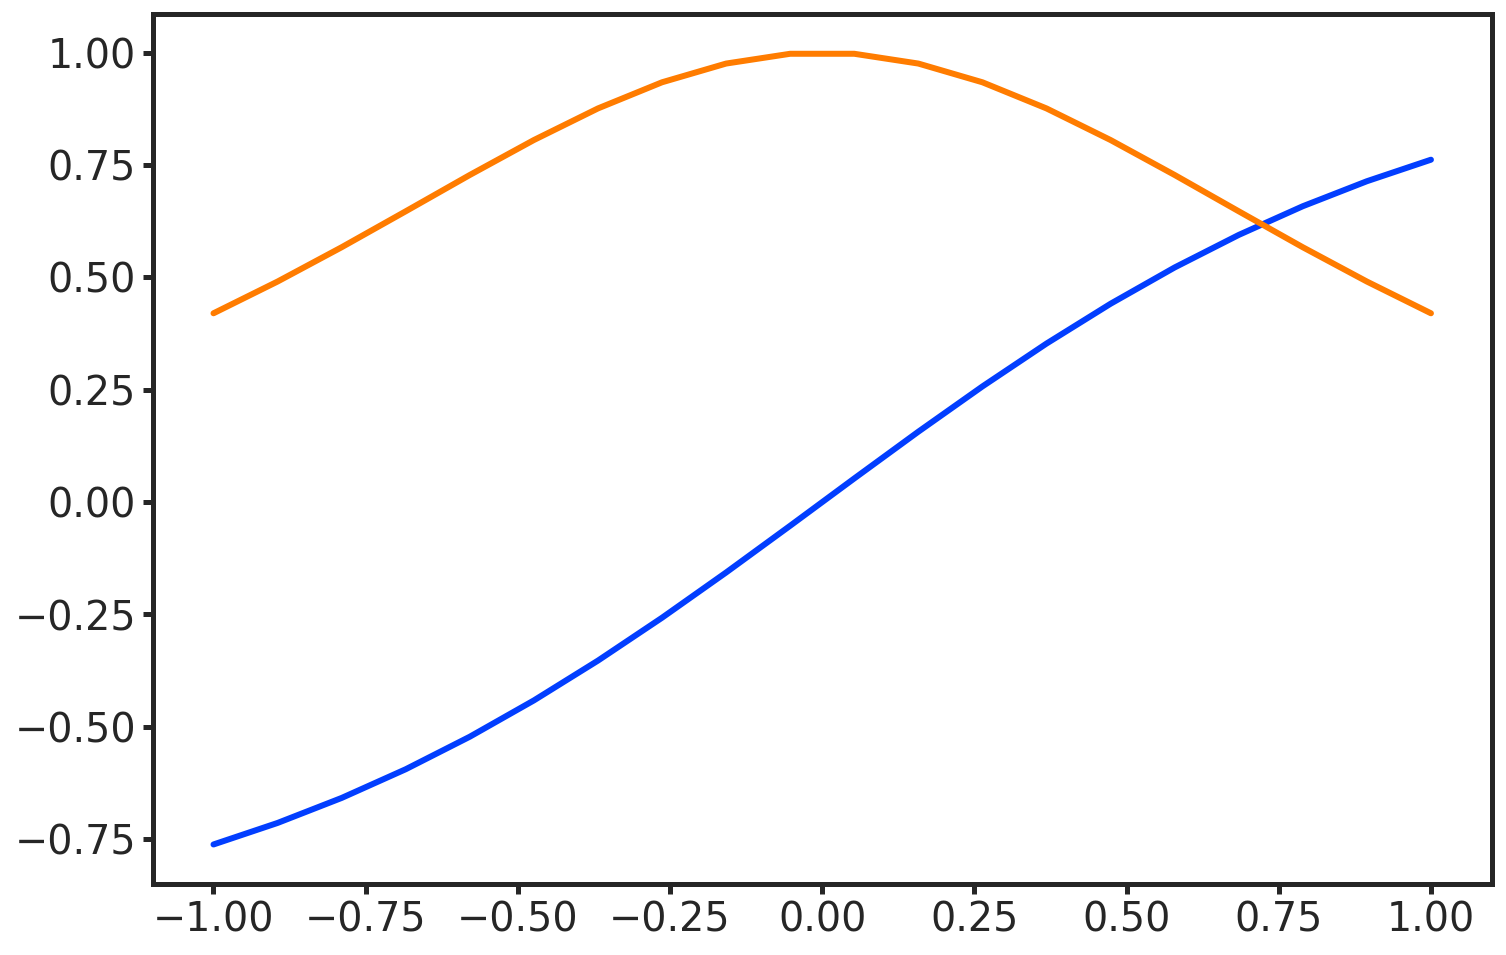

In [56]:
gtanh = jax.vmap(jax.grad(jnp.tanh))
ggtanh = jax.grad(gtanh)
gggtanh = jax.grad(ggtanh)

x_grid = np.linspace(-1, 1, 20)

plt.plot(x_grid, jnp.tanh(x_grid))
plt.plot(x_grid, gtanh(x_grid))

In [73]:
LEARNING_RATE = 0.01
@jit
def update(params, x, y):
  grads = jax.grad(loss)(params, x, y)
  return [(w - LEARNING_RATE * dw, b - LEARNING_RATE * db)
          for (w, b), (dw, db) in zip(params, grads)]

## Empieza el aprendizaje

In [74]:
BATCH_SIZE = 512
NUM_EPOCHS = 50
NUM_LABELS = 10

pbar = tqdm.tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    batch_indices = list(chunked(np.random.permutation(len(x_train)), BATCH_SIZE))[:-1]
    for batch_index in batch_indices:
        x = x_train[batch_index]
        y = y_train[batch_index]
        params = update(params, x, y)

    pbar.set_postfix({'train_acc':accuracy(params, x_train, y_train),
                      'test_acc':accuracy(params, x_test, y_test)})

# Crea un modelo CNN con Flax



In [114]:
train_ds = tfds.load(dataset_name, split=tfds.Split.TRAIN)
train_ds = train_ds.map(lambda x: {'image': tf.cast(x['image'], tf.float32),
                                    'label': tf.cast(x['label'], tf.int32)})
train_ds = train_ds.cache().shuffle(1000).batch(128)
test_ds = tfds.as_numpy(tfds.load(dataset_name, split=tfds.Split.TEST, batch_size=-1))
test_ds = {'image': test_ds['image'].astype(jnp.float32),
            'label': test_ds['label'].astype(jnp.int32)}

In [142]:
class CNN(flax.nn.Module):
  """Una red convolucional."""
  
  def apply(self, x):
    x = nn.Conv(x, features=32, kernel_size=(3, 3))
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(x, features=64, kernel_size=(3, 3))
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(x, features=256)
    embed = nn.relu(x)
    x = nn.Dense(embed, features=10)
    x = nn.log_softmax(x)
    return x,embed

In [143]:
rng = random.PRNGKey(0)
rng, init_rng = random.split(rng)
_, initial_params = CNN.init_by_shape(rng, [((1, 28, 28, 1), jnp.float32)])
model = flax.nn.Model(CNN, initial_params)

In [144]:
@jax.vmap
def cross_entropy_loss(logits, label):
  return -logits[label]

def compute_metrics(logits, labels):
  loss = jnp.mean(cross_entropy_loss(logits, labels))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return {'loss': loss, 'accuracy': accuracy}

@jax.jit
def evaluate(model, eval_ds):
  logits = model(eval_ds['image'] / 255.0)[0]
  return compute_metrics(logits, eval_ds['label'])

evaluate(model, test_ds)

{'accuracy': DeviceArray(0.09519999, dtype=float32),
 'loss': DeviceArray(2.292787, dtype=float32)}

In [145]:
@jax.jit
def train_step(optimizer, batch):
  def loss_fn(model):
    logits = model(batch['image'])[0]
    loss = jnp.mean(cross_entropy_loss(logits, batch['label']))
    return loss
  grad = jax.grad(loss_fn)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer

## Optimizador

In [146]:
optimizer = flax.optim.Momentum(learning_rate=0.1, beta=0.9).create(model)

## El training loop

In [148]:
embed_init = model(test_ds['image'])[1]
embed_init.shape

(10000, 256)

In [149]:
NUM_EPOCHS = 20
pbar = tqdm.tqdm(range(NUM_EPOCHS))
stats = []
embeds = []
for epoch in pbar:
    for batch in tfds.as_numpy(train_ds):
        batch['image'] = batch['image'] / 255.0
        optimizer = train_step(optimizer, batch)
        #embeds.append()
    stats.append(evaluate(optimizer.target, test_ds))
    pbar.set_postfix(stats[-1])


In [156]:
embed_final = model(test_ds['image'])[1]

pca_pipe = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()),
                                  ('dim_reduce', sklearn.decomposition.PCA(2))])
embed_pca_final = pca_pipe.fit_transform(embed_final)
embed_pca_init = pca_pipe.transform(embed_init)

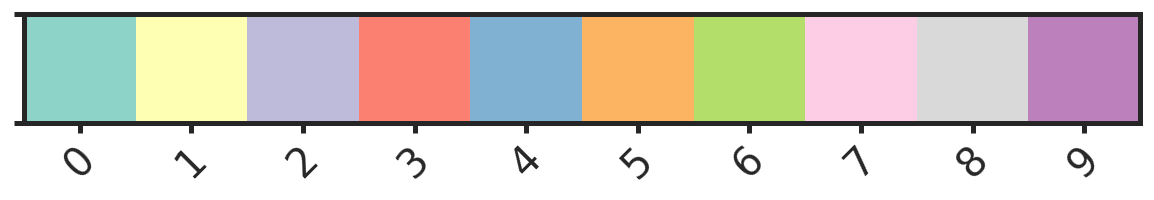

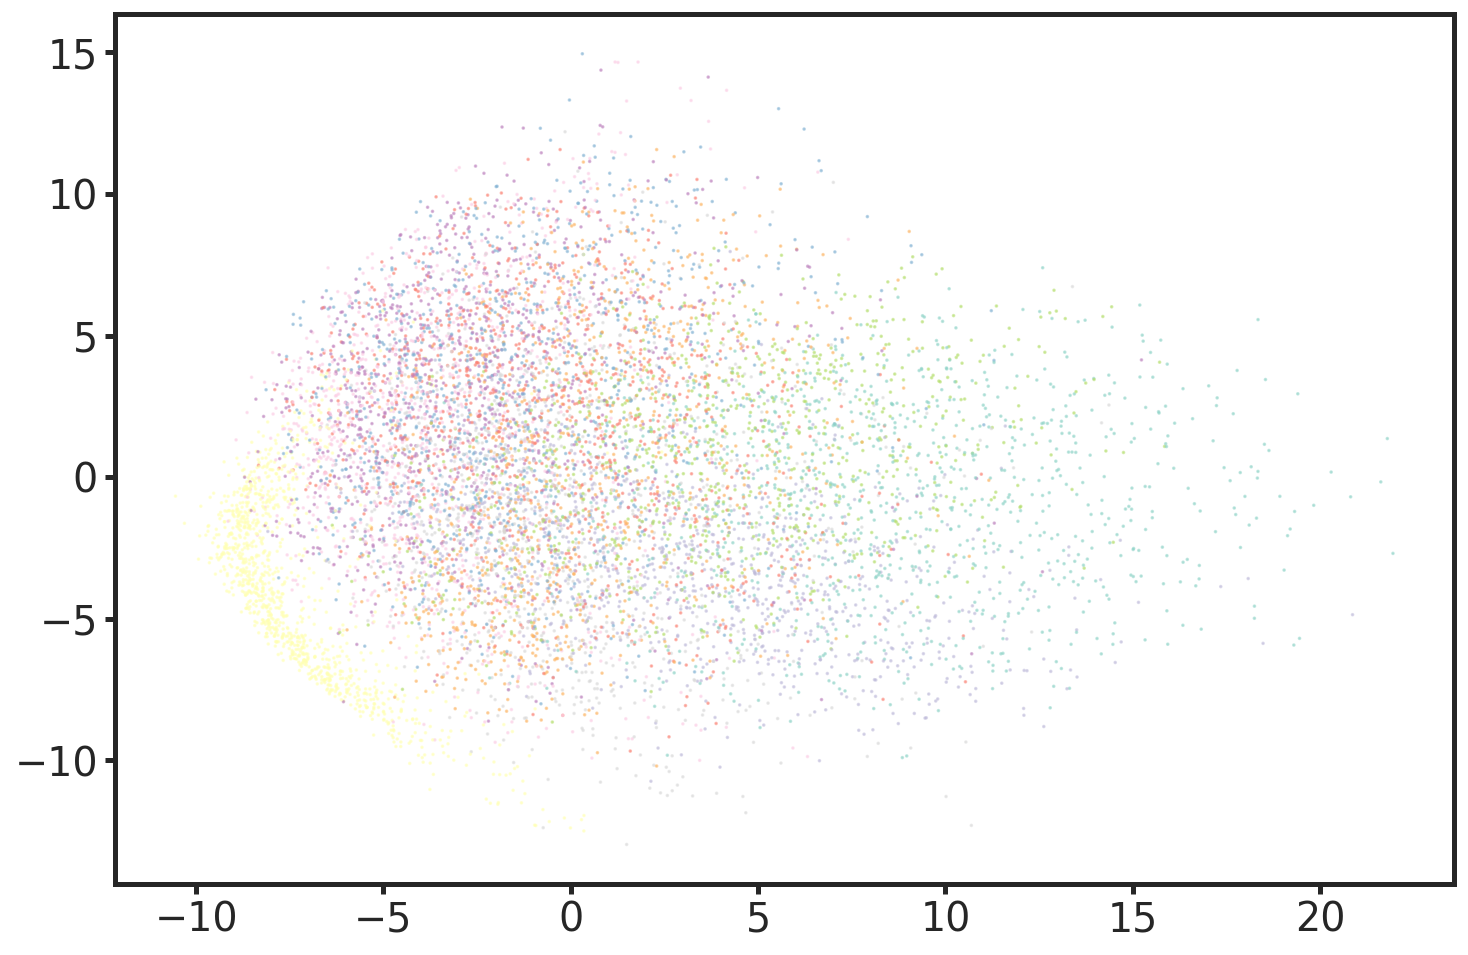

In [157]:
plot_color_legend(dataset_name)
plt.scatter(embed_pca_init[:,0], embed_pca_init[:, 1],
            c=labels_to_nodecolors(flat_y_test),
            s=1, alpha=0.5)
plt.show()

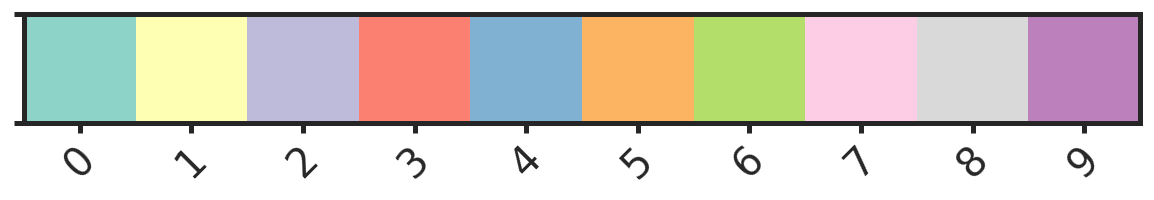

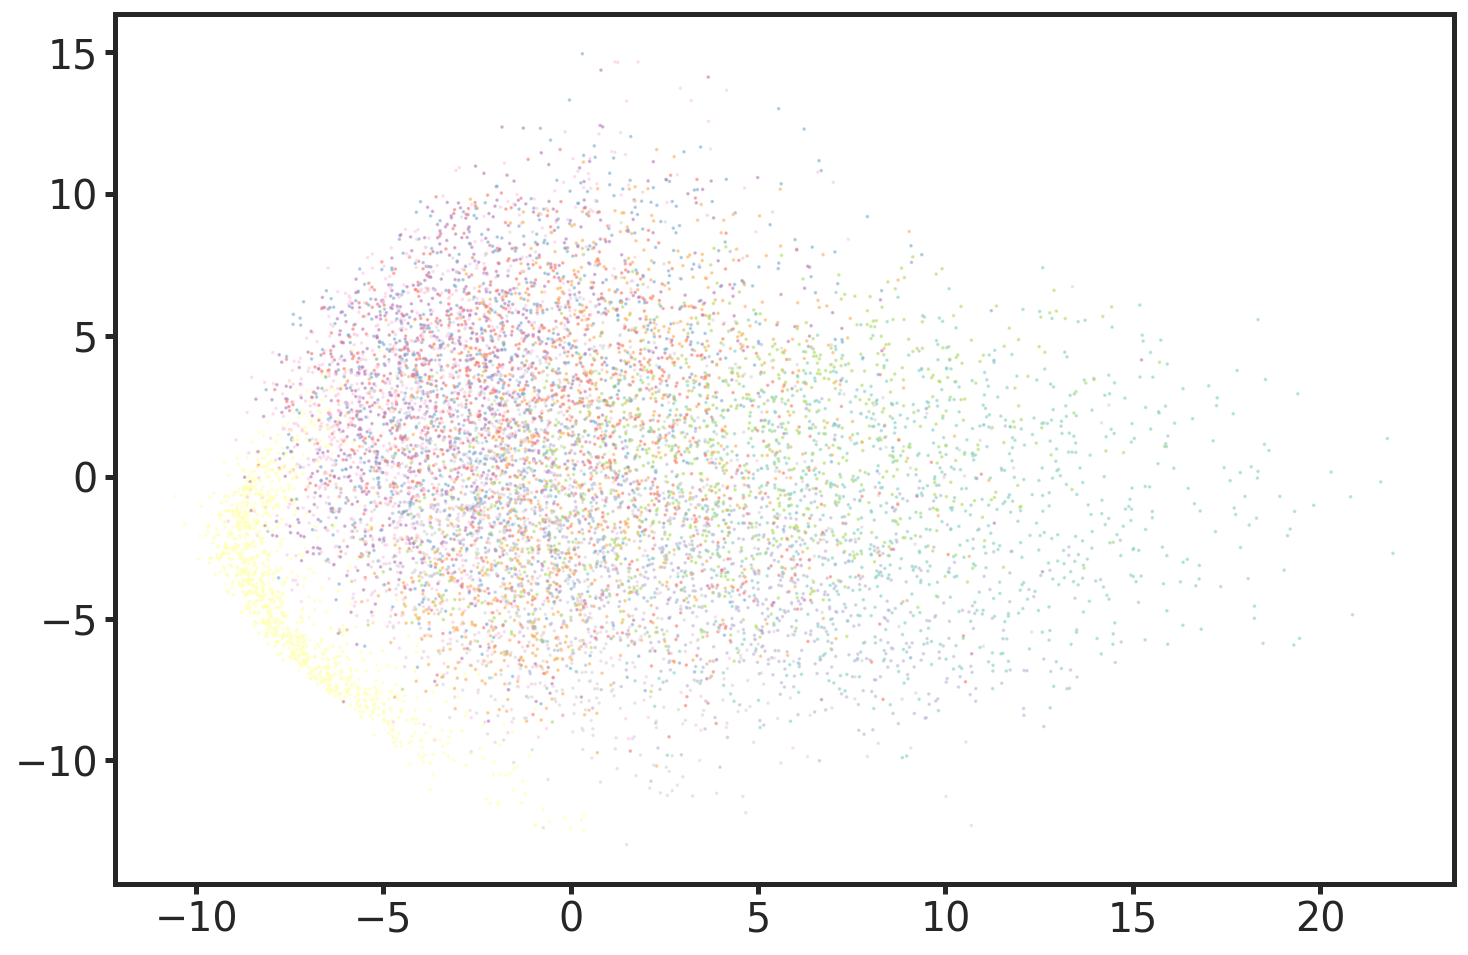

In [158]:
plot_color_legend(dataset_name)
plt.scatter(embed_pca_final[:,0], embed_pca_final[:, 1],
            c=labels_to_nodecolors(flat_y_test),
            s=1, alpha=0.5)
plt.show()

# Aprendiendo representaciones

Viendo los penultimate layer embeddings

In [113]:
class CNN2(flax.nn.Module):
  """Una red convolucional."""
  
  def embed(self, x):
    x = nn.Conv(x, features=32, kernel_size=(3, 3))
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(x, features=64, kernel_size=(3, 3))
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(x, features=256)
    x = nn.relu(x)
    return x

  def apply(self, x):
    x = self.embed(x)
    x = nn.Dense(x, features=10)
    x = nn.log_softmax(x)
    return x

<function __main__.CNN2.embed>